In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
import re
import warnings
import logging
import pickle

%matplotlib inline
pd.options.display.max_columns = 50

In [2]:
def del_read_books(recommender, yesno_df):
    recommender_mod = recommender.unstack()
    recommender_mod[yesno_df.unstack()] = np.nan
    recommender_mod = recommender_mod.unstack().transpose()
    return recommender_mod

In [25]:
def recommend_books(userid, n_books):
    """
    assumes existence of
        recommender "reconstruc_recomm_by_stars" 
        read or not df "read_yesno"
        book title list "order_in_recomm" 
    also assumes userid in recommender dataFrame
    """
    reconstruc_recomm_by_stars_exclude_read = del_read_books(reconstruc_recomm_by_stars, read_yesno)
    book_li = pd.DataFrame(reconstruc_recomm_by_stars_exclude_read.loc[userid].sort_values(ascending = False))
    book_li.index = book_li.index.droplevel()
    book_li.reset_index(inplace = True)
    book_li.columns = ['bookid', 'match_score']
    book_li = book_li.loc[:n_books].merge(order_in_recomm[['bookid', 'bk_title']], how = "left", on = 'bookid')
    return book_li

In [4]:
# this code doesn't work anymore after upgrading to pandas 0.20.1,
# will get ModuleNotFoundError: No module named 'pandas.indexes'
# with open("cleaned_data.pkl", 'rb') as picklefile: 
#     book_review = pickle.load(picklefile)
book_review = pd.read_pickle("cleaned_data.pkl")

In [5]:
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len
19230,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234


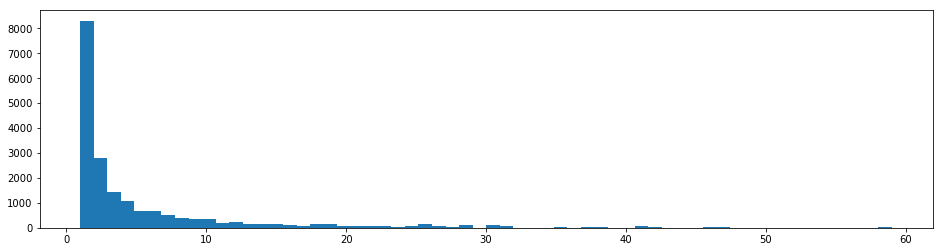

In [6]:
plt.figure(figsize = (16, 4))
plt.hist(book_review['user_tot_reviews'], bins = 60)
plt.show()

In [8]:
min(book_review['user_tot_reviews'])

1

In [7]:
# TODO don't cut down users or cut more?
cond = book_review['user_tot_reviews'] > 1
recomm_by_stars = pd.pivot_table(book_review.loc[cond], values=["review_rating"],
                                 index=["userid", "bookid"],
                                 aggfunc=np.mean).unstack()
print(len(book_review['userid'].unique()), "total users")
print(len(book_review['bookid'].unique()), "total books")
print(recomm_by_stars.shape)

11372 total users
931 total books
(3067, 734)


### get read_yesno and bk_title_cols for later use

In [9]:
read_yesno = np.isnan(recomm_by_stars) == False
print(read_yesno.shape)
read_yesno.iloc[:5, :5]

(3067, 734)


review_rating                            
bookid           1      3      350    415    662
userid                                          
8561           False  False  False  False  False
13779          False  False  False  False  False
16600          False  False  False  False  False
19993          False  False  False  False  False
26259          False  False  False  False  False

In [10]:
bk_title_cols = book_review[['bookid', 'bk_title']].drop_duplicates()
bk_title_cols = bk_title_cols.sort_values('bookid')

order_in_recomm = pd.DataFrame([x[1] for x in read_yesno.columns])
order_in_recomm.reset_index(inplace = True)
order_in_recomm.columns = ['order', 'bookid']
order_in_recomm = order_in_recomm.merge(bk_title_cols, how = "left", on = "bookid")
order_in_recomm = order_in_recomm.sort_values('order')

In [11]:
mean_rating = np.mean(book_review['review_rating'].groupby(np.ones(len(book_review))).agg([min, max]).loc[1])
recomm_by_stars = recomm_by_stars.fillna(mean_rating)
recomm_by_stars.iloc[:5, :5]

review_rating                    
bookid           1    3    350  415  662
userid                                  
8561             3.0  3.0  3.0  3.0  3.0
13779            3.0  3.0  3.0  3.0  3.0
16600            3.0  3.0  3.0  3.0  3.0
19993            3.0  3.0  3.0  3.0  3.0
26259            3.0  3.0  3.0  3.0  3.0

In [12]:
init_n_components = min(recomm_by_stars.shape) - 1
init_n_components

733

In [13]:
tSVD_model = TruncatedSVD(n_components = init_n_components)
tSVD_model.fit(recomm_by_stars)

TruncatedSVD(algorithm='randomized', n_components=733, n_iter=5,
       random_state=None, tol=0.0)

In [14]:
var_ratio_df = pd.DataFrame(tSVD_model.explained_variance_ratio_)
var_ratio_df.columns = ['var_ratio']
var_ratio_df['cum_var_ratio'] = var_ratio_df['var_ratio'].cumsum()
var_ratio_df.head(1)

,var_ratio,cum_var_ratio
0,0.003072,0.003072


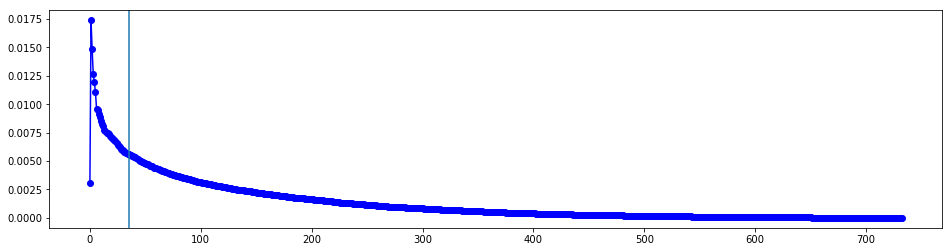

In [15]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['var_ratio'], 'b-o')
plt.axvline(35)
plt.show()

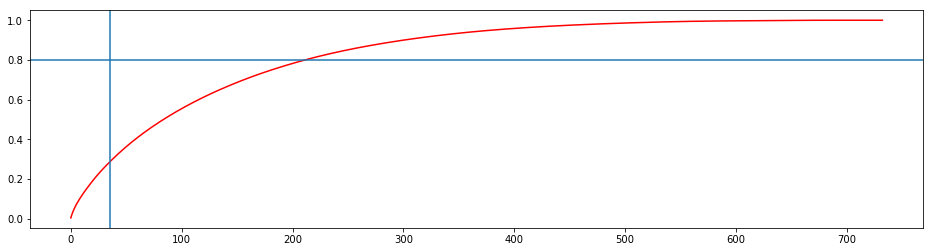

In [16]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['cum_var_ratio'], 'r-')
plt.axvline(35)
plt.axhline(0.8)
plt.show()


In [17]:
elbow_n_components = 35 # TODO Or 200? Tune this?

In [18]:
U, Sigma, VT = randomized_svd(recomm_by_stars, 
                              n_components=elbow_n_components,
                              n_iter=5,
                              random_state=None)
print(recomm_by_stars.shape, U.shape, Sigma.shape, VT.shape)

(3067, 734) (3067, 35) (35,) (35, 734)


In [19]:
reconstruc_recomm_by_stars = pd.DataFrame(np.dot(U, np.dot(np.diag(Sigma), VT)))
reconstruc_recomm_by_stars.index = recomm_by_stars.index
reconstruc_recomm_by_stars.columns = recomm_by_stars.columns
print(reconstruc_recomm_by_stars.shape)
reconstruc_recomm_by_stars.iloc[:5, :5]

(3067, 734)


review_rating                                        
bookid           1         3         350       415       662
userid                                                      
8561        2.988310  3.001500  2.993537  3.000731  2.995761
13779       3.004723  3.002238  2.987447  2.995907  2.991167
16600       2.963425  2.974567  2.998083  3.008983  2.998914
19993       2.999659  3.001677  2.993782  2.998851  2.994232
26259       2.919213  2.984803  3.019775  3.011841  2.996635

### test it out

In [26]:
recommend_books(8561, 5)

,bookid,match_score,bk_title
0,38180,3.017926,On the Beach
1,61886,3.017846,The Curse of Chalion
2,26892110,3.017201,The Library at Mount Char
3,920607,3.016680,The Arrival
4,56842,3.016511,Fatherland
5,6148028,3.015308,Catching Fire


### pickle star recommender

In [21]:
reconstruc_recomm_by_stars.to_pickle("star_recommender.pkl")
read_yesno.to_pickle("read_yesno.pkl")
order_in_recomm.to_pickle("star_recommender_order.pkl")